# **Implementation of the Vision Transformer for Object Detection**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing Libraries**

In [3]:

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import os
import json

## **Data Preprocessing**

In [4]:

tomato_base_dir = "/content/drive/MyDrive/tomato/"
path_images_train = os.path.join(tomato_base_dir, "train/")
path_annot_train = os.path.join(tomato_base_dir, "train/_annotations.coco.json")

In [5]:
def custom_collate(batch):
    images, targets = zip(*batch)

    resized_images = [transforms.functional.resize(img, (32, 32)) for img in images]

    return resized_images, targets

In [6]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set your paths
tomato_base_dir = "/content/drive/MyDrive/tomato/"
path_images_train = os.path.join(tomato_base_dir, "train/")
path_annot_train = os.path.join(tomato_base_dir, "train/_annotations.coco.json")

# Define your transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed (e.g., normalization, data augmentation)
])

# Create a CocoDataset using torchvision
coco_dataset = CocoDetection(root=path_images_train, annFile=path_annot_train, transform=transform)

# Define a DataLoader
trainloader = DataLoader(coco_dataset, batch_size=32, shuffle=True,collate_fn=custom_collate)

# Get one batch of images and annotations
dataiter = iter(trainloader)
images, targets = next(dataiter)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## **Dividing the images into patches**

In [7]:

def split_image_into_patches(images, patch_size):
    batch_size, num_channels, height, width = images.shape
    num_vert_patches = height // patch_size
    num_horiz_patches = width // patch_size

    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.reshape(batch_size, num_channels, num_vert_patches*num_horiz_patches, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    patches = patches.reshape(batch_size, num_vert_patches*num_horiz_patches, num_channels*patch_size*patch_size)

    return patches

## **Visualizing the patches**

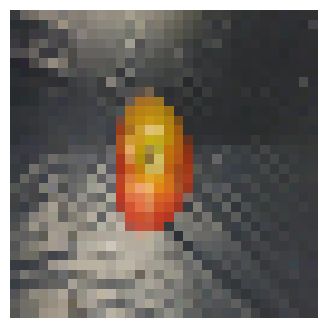

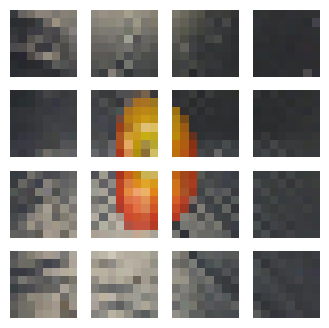

In [8]:
# Get one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Get one image from the batch
image = images[0]

# Split the image into patches
patches = split_image_into_patches(image.unsqueeze(0), 8)

# Calculate the number of patches in each dimension to create a 4x4 grid of 4x4 patches
num_patches = patches.shape[1]
num_cols = 4
num_rows = 4

# Display the original image
plt.figure(figsize=(4,4))
plt.imshow(np.moveaxis(image.numpy(), 0, -1))
plt.axis('off')
plt.show()

# Display the patches in a grid format
plt.figure(figsize=(4,4))
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i*num_cols+j+1)
        plt.imshow(np.transpose(patches[0, i*num_cols+j].reshape(3,8,8), (1,2,0)))
        plt.axis('off')
plt.show()

## **Function that takes the flattened patches and projects it to the embedding dimension**

In [9]:

def embed_patches(patches, embedding_dim):

    # Define the linear embedding layer
    embed_layer = nn.Linear(in_features=patches.shape[-1], out_features=embedding_dim)

    # Apply the embedding layer to the flattened tensor
    embed_patches = embed_layer(patches)  # shape: [num_images * num_patches, embedding_dim]

    return embed_patches

## **Function to add the positional encoding to the embedding patches**


In [10]:
def get_position_encoding(embeddings):
    num_images, num_patches, embedding_dim = embeddings.shape
    seq_length = num_patches * num_images
    num_patches = num_patches
    num_images = num_images

    pos_encoding = torch.zeros(seq_length, embedding_dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float) * (-math.log(10000.0) / embedding_dim))
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    pos_encoding = pos_encoding[:num_patches, :].unsqueeze(0).repeat(num_images, 1, 1)
    pos_encoding = pos_encoding.reshape(-1, pos_encoding.size(-1))
    pos_encoding = pos_encoding.view(num_images, num_patches, embedding_dim)

    return pos_encoding


## **Encoder block function with Multi-head attention and the fully connected network**


In [11]:
# Define the Encoder block with multi-head attention
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 6*embed_dim),
            nn.GELU(),
            nn.Linear(6*embed_dim, embed_dim)
        )

    def forward(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Multi-head attention with residual connection
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_output

        # Layer normalization
        x_norm = self.norm2(x)

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x_norm)
        x = x + ffn_output

        return x

## **MLP Classifer Head**

In [12]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc3(out)
        return out

## **Implementation of the ViT base Model for object Detection**

In [49]:
class ViTObjectDetector(nn.Module):

    def __init__(self, inputs, patch_size, embed_dim, num_heads, mlp_head_units, hidden_size_classifier, num_classes_classifier, device):
        super(ViTObjectDetector, self).__init__()

        self.inputs = inputs
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_head_units = mlp_head_units
        self.hidden_size_classifier = hidden_size_classifier
        self.num_classes_classifier = num_classes_classifier
        self.device = device

        # Create class token
        self.class_token = nn.Parameter(torch.rand(1, self.embed_dim))

        # Create Encoder blocks
        encoder_blocks = []
        for i in range(12):
            encoder_blocks.append(EncoderBlock(self.embed_dim, self.num_heads))
        self.encoder_block = nn.Sequential(*encoder_blocks)

        # MLP head for object detection
        self.mlp_head = nn.Sequential(
            nn.Linear(2176, mlp_head_units),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_head_units, 4)  # Final four neurons that output bounding box
        )

        # MLP Classifier
        self.classifier = MLPClassifier(
            input_size=2176,
            hidden_size=hidden_size_classifier,
            num_classes=num_classes_classifier
        )

    def forward(self, inputs):
        # Split image into patches
        patches = split_image_into_patches(inputs, self.patch_size)

        # Embed patches
        embed_layer = embed_patches(patches, self.embed_dim)
        embedded_tokens = torch.stack([torch.vstack((self.class_token, embed_layer[i])) for i in range(len(embed_layer))])

        # Get position encoding
        pos_encoding = get_position_encoding(embedded_tokens)

        # Add position encoding to embedded patches
        embedded_patches = embedded_tokens + pos_encoding

        # Process through Encoder blocks
        encoded_sequence = self.encoder_block(embedded_patches)

        # Flatten for MLP
        flattened_representation = encoded_sequence.flatten(1)

        # Apply MLP for object detection
        bounding_box = self.mlp_head(flattened_representation)

        # Apply MLP Classifier
        classification_output = self.classifier(flattened_representation)

        return bounding_box, classification_output



In [50]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTObjectDetector(inputs = (32,3,32,32), patch_size=8, embed_dim = 128, num_heads= 4, mlp_head_units = 512, hidden_size_classifier=512,
    num_classes_classifier=3 , device=device )

model.to(device)

ViTObjectDetector(
  (encoder_block): Sequential(
    (0): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=768, out_features=128, bias=True)
      )
    )
    (1): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2):

In [51]:
for images, targets in trainloader:
  print(targets)

  break

([{'id': 431, 'image_id': 433, 'category_id': 3, 'bbox': [181, 150, 180, 323.5], 'area': 58230, 'segmentation': [], 'iscrowd': 0}], [{'id': 379, 'image_id': 381, 'category_id': 2, 'bbox': [163, 184, 235, 330], 'area': 77550, 'segmentation': [], 'iscrowd': 0}], [{'id': 241, 'image_id': 242, 'category_id': 2, 'bbox': [175, 163, 227.5, 356.5], 'area': 81103.75, 'segmentation': [], 'iscrowd': 0}], [{'id': 448, 'image_id': 451, 'category_id': 1, 'bbox': [181, 157, 252.5, 323.5], 'area': 81683.75, 'segmentation': [], 'iscrowd': 0}], [{'id': 451, 'image_id': 454, 'category_id': 1, 'bbox': [156, 145, 269, 366.5], 'area': 98588.5, 'segmentation': [], 'iscrowd': 0}], [{'id': 261, 'image_id': 262, 'category_id': 2, 'bbox': [158, 125, 250, 398.5], 'area': 99625, 'segmentation': [], 'iscrowd': 0}], [{'id': 382, 'image_id': 384, 'category_id': 1, 'bbox': [173, 95, 229, 363.5], 'area': 83241.5, 'segmentation': [], 'iscrowd': 0}], [{'id': 202, 'image_id': 201, 'category_id': 1, 'bbox': [148, 219, 393.

In [52]:
import torch.optim as optim

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
bbox_criterion = nn.MSELoss()  # You might need a different loss function based on your requirements
class_criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_bbox_loss = 0.0
    total_class_loss = 0.0

    for images_list, targets_list in trainloader:
        # Unpack images from the list
        images = torch.stack(images_list).to(device)

        # Extract bounding box and class information from targets
        # Extract bounding box and class information from targets
        bbox_targets = torch.stack([torch.tensor(target[0]['bbox']) if target else torch.zeros(4) for target in targets_list])
        class_targets = torch.tensor([target[0]['category_id'] - 1 if target else 0 for target in targets_list])


        # Forward pass
        bbox_pred, class_pred = model(images)

        # Calculate the loss
        bbox_loss = bbox_criterion(bbox_pred, bbox_targets.to(device))
        class_loss = class_criterion(class_pred, class_targets.to(device))

        total_bbox_loss += bbox_loss.item()
        total_class_loss += class_loss.item()

        # Backward pass and optimization
        total_loss = bbox_loss + class_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Print training statistics for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Class Loss: {total_class_loss / len(trainloader)}')




Epoch 1/10, Bbox Loss: 20171.278287760415, Class Loss: 9.570457450548808
Epoch 2/10, Bbox Loss: 6487.724674479166, Class Loss: 4.777041284243266
Epoch 3/10, Bbox Loss: 6335.984895833333, Class Loss: 2.8295247276624043
Epoch 4/10, Bbox Loss: 6196.059342447917, Class Loss: 1.974535083770752
Epoch 5/10, Bbox Loss: 6324.840299479167, Class Loss: 1.112716011206309
Epoch 6/10, Bbox Loss: 6161.612467447917, Class Loss: 1.0371227423350016
Epoch 7/10, Bbox Loss: 6170.36630859375, Class Loss: 1.0293525258700054
Epoch 8/10, Bbox Loss: 6250.983333333334, Class Loss: 1.1162301381429036
Epoch 9/10, Bbox Loss: 6038.5076171875, Class Loss: 1.0928051829338075
Epoch 10/10, Bbox Loss: 6125.462272135416, Class Loss: 1.0716545740763346


In [53]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/tomato/vit_base')

In [93]:
# Set your paths
tomato_base_dir = "/content/drive/MyDrive/tomato/"
path_images_test = os.path.join(tomato_base_dir, "test/")
path_annot_test = os.path.join(tomato_base_dir, "test/_annotations.coco.json")

# Define your transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed (e.g., normalization, data augmentation)
])

# Create a CocoDataset using torchvision
coco_dataset_test = CocoDetection(root=path_images_test, annFile=path_annot_test, transform=transform)

# Define a DataLoader
testloader = DataLoader(coco_dataset_test, batch_size=68, shuffle=True,collate_fn=custom_collate)

# Get one batch of images and annotations
dataiter_test = iter(testloader)
images_test, targets_test = next(dataiter_test)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [94]:
model.load_state_dict(torch.load('/content/drive/MyDrive/tomato/vit_base'))
model.eval()

ViTObjectDetector(
  (encoder_block): Sequential(
    (0): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=768, out_features=128, bias=True)
      )
    )
    (1): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2):

In [95]:
# targets_test

In [107]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Iterate through the test data
for images_test, targets_test in testloader:
    with torch.no_grad():
        # Forward pass
        images_test = torch.stack(images_test).to(device)
        outputs = model(images_test)

    # Process the model outputs as needed
    predicted_bboxes = outputs[0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [108]:
predicted_bboxes

tensor([[154.5918, 145.1677, 252.5915, 311.2989],
        [154.5825, 145.1823, 252.6270, 311.3213],
        [154.6422, 145.1891, 252.7245, 311.4163],
        [154.5977, 145.1748, 252.5926, 311.2912],
        [154.7196, 145.2121, 252.8145, 311.4650],
        [154.5969, 145.1715, 252.6223, 311.3131],
        [154.5860, 145.1788, 252.6142, 311.3138],
        [154.5809, 145.1741, 252.6109, 311.3124],
        [154.5404, 145.1367, 252.5422, 311.2368],
        [154.6101, 145.2837, 252.8716, 311.6036],
        [154.5780, 145.1716, 252.6046, 311.3022],
        [154.5773, 145.1630, 252.5809, 311.2749],
        [154.6003, 145.1806, 252.6159, 311.3140],
        [154.6014, 145.1711, 252.6027, 311.2998],
        [154.5752, 145.1721, 252.6071, 311.3030],
        [154.5807, 145.1660, 252.5906, 311.2814],
        [154.5779, 145.1736, 252.6108, 311.3057],
        [154.5869, 145.1645, 252.5980, 311.2877],
        [154.5932, 145.1733, 252.6158, 311.3058],
        [154.7053, 145.2645, 252.8532, 311.5601],


In [72]:
predicted_bboxes = outputs[0].cpu().numpy()
predicted_bboxes[0]

array([154.97855, 145.37875, 252.71478, 311.58182], dtype=float32)